In [43]:
## Get data

import pandas as pd
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.stats import binned_statistic_2d
from trajectory import rat_trajectory
from scipy.ndimage import gaussian_filter
from matplotlib.patches import RegularPolygon

#Perameters
shape = 'Tri'
cell_num = 78

cell_name = f' C{cell_num:03}'
spk_filename = f'data/B6_8_1_{shape}_Spike.csv'
trc_filename = f'data/B6_8_1_{shape}_Trace.csv'

# Read the CSV file
df = pd.read_csv(trc_filename, header=None)

# Get cell numbers
cell_numbers = df.iloc[0].dropna().tolist()[1:]
spike_times = {cell: [] for cell in cell_numbers}

# Get time data
time_data = [float(i) for i in df.iloc[2:, 0].tolist()]
start_time = time_data[0]
time_data = [time_data[i] - start_time for i in range(len(time_data))]

with open(spk_filename, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        time = float(row[0]) - start_time
        cell = row[1]
        if cell in spike_times:
            spike_times[cell].append(time)

traj_time, x_pos, y_pos, head_dir, velocity = rat_trajectory(shape)

In [44]:
## NaN interpolation ##
# For x_pos
invalid_x_pos = np.isnan(x_pos)
x_pos_interp = x_pos.copy()
x_valid = np.where(~invalid_x_pos)[0]
x_pos_interp[invalid_x_pos] = np.interp(np.where(invalid_x_pos)[0], x_valid, x_pos[x_valid])

# For y_pos
invalid_y_pos = np.isnan(y_pos)
y_pos_interp = y_pos.copy()
y_valid = np.where(~invalid_y_pos)[0]
y_pos_interp[invalid_y_pos] = np.interp(np.where(invalid_y_pos)[0], y_valid, y_pos[y_valid])

# For HD
invalid_hd = np.isnan(head_dir)
hd_interp = head_dir.copy()
hd_valid = np.where(~invalid_hd)[0]
hd_interp[invalid_hd] = np.interp(np.where(invalid_hd)[0], hd_valid, head_dir[hd_valid])

# Update the original arrays
x_pos = x_pos_interp
y_pos = y_pos_interp
head_dir = hd_interp

# discard index where velocity < threshold
threshold = 2
moving_idx = [i for i, x in enumerate(velocity) if x > threshold]


In [45]:
def find_nearest_time_index(spike_time, traj_time):
    return np.argmin(np.abs(np.array(traj_time) - spike_time))

# Create a 2D array with zeros (rows: time points, columns: cells)
spiking_data = np.zeros((len(traj_time), len(cell_numbers)))

# Iterate through cells and their spike times
for i, cell in enumerate(cell_numbers):
    for spike_time in spike_times[cell]:
        nearest_index = find_nearest_time_index(spike_time, traj_time)
        if nearest_index in moving_idx:
            spiking_data[nearest_index, i] = 1

print(np.shape(spiking_data))

(26988, 73)


In [46]:
print(np.shape(x_pos))

(26988,)


In [47]:
# normalize
x_pos = x_pos / 10
y_pos = y_pos / 10

In [48]:
# to radial coordinates
x_pos_ori, y_pos_ori = x_pos, y_pos
theta = np.arctan(x_pos / y_pos)
rad = np.sqrt(x_pos ** 2 + y_pos ** 2)

x_pos, y_pos = rad, theta

In [49]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.collections import LineCollection

import cebra.datasets
import cebra
from cebra import CEBRA

In [50]:
max_iterations = 1000 #default is 5000.

In [51]:
'''
Tri-spiking at vertex as id : # 11, 78, 50, 68, 84, 122, 133 -> 5, 46, 30, 41, 46, 50, 67, 70
Tri-spiking at boundary as id : # 10, 11, 13, 18, 32, 45, 69, 78, 79, 94, 99, 101, 106, 122, 133

Thsh-Hex-spiking at boundary as id : # 4, 11, (16), 27, 32, 35, 41, 57, 71, 72, 76, 90, 105, 131
Hex grid cells? 83, 120

Thsh-Sqr-spiking at boundary as id : 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15,16, 17, 18, 19, 24, 25, 32, 34, 35, 36, 38, 39, 41, 43, 45, 51, 55, 61, 63, 64, 66, 67, 68, 71, 72, 78, 92, 97, 102, 105, 111, 112, 121, 129

Thsh-Hex-spiking at boundary as id : 0, 1, 4, 5, 6,8, 9, 10, 11, 21, 22, 27, 32, 35, 36, 38, 41, 48, 49, 57, 60, 62, 68, 69, 71, 72, 73, 76, 86, 90, 93, 94, 96, 105, 119
'''

continuous_index = np.column_stack((x_pos, y_pos, head_dir/180))
index = []
id = np.array([0, 1, 4, 5, 6,8, 9, 10, 11, 21, 22, 27, 32, 35, 36, 38, 41, 48, 49, 57, 60, 62, 68, 69, 71, 72, 73, 76, 86, 90, 93, 94, 96, 105, 119])
cnt = 0
for i, cell in enumerate(cell_numbers):
    if (cnt == len(id)):
        break
    if cell == f' C{id[cnt]:03}':
        index.append(i)
        cnt += 1
    else:
        continue

print(index)
neural = spiking_data[:, :] #index at 2

[0]


In [52]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.5,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir3_model.fit(neural, continuous_index)
cebra_posdir3_model.save("cebra_posdir3_model.pt")

cebra_posdir8_model.fit(neural, continuous_index)
cebra_posdir8_model.save("cebra_posdir8_model.pt")

cebra_posdir16_model.fit(neural, continuous_index)
cebra_posdir16_model.save("cebra_posdir16_model.pt")

pos: -0.2376 neg:  6.3438 total:  6.1063 temperature:  1.5000: 100%|██████████| 1000/1000 [01:24<00:00, 11.81it/s]
pos: -0.1499 neg:  6.3104 total:  6.1605 temperature:  1.5000: 100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]
pos: -0.2470 neg:  6.3311 total:  6.0842 temperature:  1.5000: 100%|██████████| 1000/1000 [02:22<00:00,  7.03it/s]


In [53]:
cebra_posdir3_model = cebra.CEBRA.load("cebra_posdir3_model.pt")
cebra_posdir3 = cebra_posdir3_model.transform(neural)

cebra_posdir8_model = cebra.CEBRA.load("cebra_posdir8_model.pt")
cebra_posdir8 = cebra_posdir8_model.transform(neural)

cebra_posdir16_model = cebra.CEBRA.load("cebra_posdir16_model.pt")
cebra_posdir16 = cebra_posdir16_model.transform(neural)

In [54]:
np.shape(cebra_posdir3)

(26988, 3)

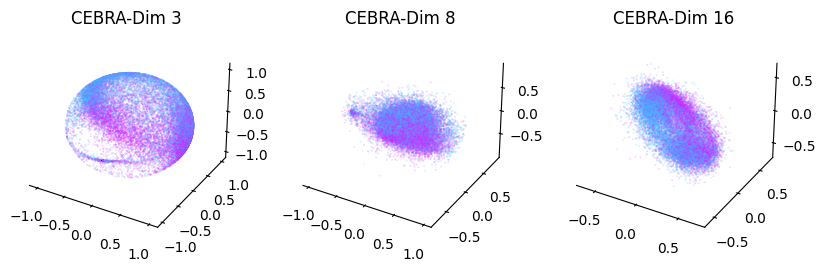

In [66]:
from matplotlib import pyplot as plt

embedding_labels=continuous_index[:, 1]

fig = plt.figure(figsize = (10,3), dpi = 100)
ax1 = plt.subplot(131,projection='3d')
ax1 = cebra.plot_embedding(ax=ax1, embedding=cebra_posdir3[:,:], embedding_labels=embedding_labels, cmap="cool")
ax2 = plt.subplot(132,projection='3d')
ax2 = cebra.plot_embedding(ax=ax2, embedding=cebra_posdir8[:,:], embedding_labels=embedding_labels, cmap="cool")
ax3 = plt.subplot(133,projection='3d')
ax3 = cebra.plot_embedding(ax=ax3, embedding=cebra_posdir16[:,:], embedding_labels=embedding_labels, cmap="cool")

ax1.set_title('CEBRA-Dim 3')
ax2.set_title('CEBRA-Dim 8')
ax3.set_title('CEBRA-Dim 16')
plt.savefig('./Figures-cebra/0717_BVC_Tri_all_HD_theta')
plt.show()

In [56]:
print(cebra_posdir3)

[[-0.46224454 -0.86522228 -0.19421762]
 [-0.55445027  0.73260647 -0.39480701]
 [ 0.40366137  0.86838257 -0.28804392]
 ...
 [ 0.97254843  0.15902248  0.16988677]
 [ 0.95798051  0.25982481  0.12150937]
 [ 0.97116923  0.21208286  0.10886319]]


In [64]:
# Normalize continuous_index to 0-1 range
def renormalize_angle(x):
    if x < 0:
        return x + 1
    else:
        return x - 1
    
# embedding_labels = np.array([renormalize_angle(x) for x in embedding_labels])
norm = plt.Normalize(embedding_labels.min(), embedding_labels.max())
normalized_index = norm(embedding_labels)

# Choose colormap ('cool' or 'viridis')
cmap = plt.get_cmap('plasma')  # or 'viridis'

# Get RGB values (0-1 range)
colors_float = cmap(normalized_index)[:, :3]

# Convert to 0-255 range for PLY file
colors = (colors_float * 255).astype(int)
print(colors)
# Function to write colored PLY file
def write_colored_ply(filename, points, colors):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for point, color in zip(points, colors):
            f.write(f"{point[0]} {point[1]} {point[2]} {color[0]} {color[1]} {color[2]}\n")

# Write the colored PLY file
dim = 3
write_colored_ply(f"colored_points_{dim}.ply", cebra_posdir3, colors)
dim = 8
write_colored_ply(f"colored_points_{dim}.ply", cebra_posdir8, colors)
dim = 16
write_colored_ply(f"colored_points_{dim}.ply", cebra_posdir16, colors)

[[231 110  90]
 [232 113  88]
 [232 112  89]
 ...
 [150  18 160]
 [146  15 162]
 [146  15 162]]


In [18]:
shuffled_index = np.random.permutation(np.column_stack((x_pos, y_pos)))
# index = (5, 46) #30, 41, 46, 50, 67, 70
neural = spiking_data[:, index] # 78, 50, 68, 84, 122, 133

shuffled_cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir3_model.fit(neural, shuffled_index)
shuffled_cebra_posdir3_model.save("shuffled_cebra_posdir3_model.pt")

shuffled_cebra_posdir8_model.fit(neural, shuffled_index)
shuffled_cebra_posdir8_model.save("shuffled_cebra_posdir8_model.pt")

shuffled_cebra_posdir16_model.fit(neural, shuffled_index)
shuffled_cebra_posdir16_model.save("shuffled_cebra_posdir16_model.pt")

pos: -0.7307 neg:  6.9297 total:  6.1990 temperature:  1.0000: 100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]
pos: -0.5445 neg:  6.7451 total:  6.2006 temperature:  1.0000: 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]
pos: -0.5384 neg:  6.7100 total:  6.1716 temperature:  1.0000: 100%|██████████| 1000/1000 [02:55<00:00,  5.68it/s]


In [13]:
shuffled_cebra_posdir3_model = cebra.CEBRA.load("shuffled_cebra_posdir3_model.pt")
shuffled_cebra_posdir3 = shuffled_cebra_posdir3_model.transform(neural)

shuffled_cebra_posdir8_model = cebra.CEBRA.load("shuffled_cebra_posdir8_model.pt")
shuffled_cebra_posdir8 = shuffled_cebra_posdir8_model.transform(neural)

shuffled_cebra_posdir16_model = cebra.CEBRA.load("shuffled_cebra_posdir16_model.pt")
shuffled_cebra_posdir16 = shuffled_cebra_posdir16_model.transform(neural)

RuntimeError: Given groups=1, weight of size [32, 14, 2], expected input[1, 77, 26999] to have 14 channels, but got 77 channels instead

In [34]:
import ripser

maxdim=1 # set to 2 to compute up to H2. The computing time is considerably longer. 

np.random.seed(111)
random_idx=np.random.permutation(np.arange(len(cebra_posdir3)))[:1000]
topology_dimension = {}
for embedding in [cebra_posdir3, cebra_posdir8, cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_dimension[dimension] = ripser_output

: 

In [21]:
np.random.seed(111)
topology_random_dimension = {}
for embedding in [shuffled_cebra_posdir3, shuffled_cebra_posdir8, shuffled_cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_random_dimension[dimension] = ripser_output

In [22]:
print(np.shape(np.asarray(topology_random_dimension[3]['dgms'][0])))

(861, 2)


In [23]:
def plot_barcode(topology_result, maxdim):
    fig, axs = plt.subplots(maxdim+1, 1, sharex=True, figsize=(7, 8))
    axs[0].set_xlim(0,2)
    cocycle = ["Points", "Loops", "Voids"]
    for k in range(maxdim+1):
        bars = topology_result['dgms'][k]
        bars[bars == np.inf] = 10
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 6 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np
                              .linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)
    
    return fig 

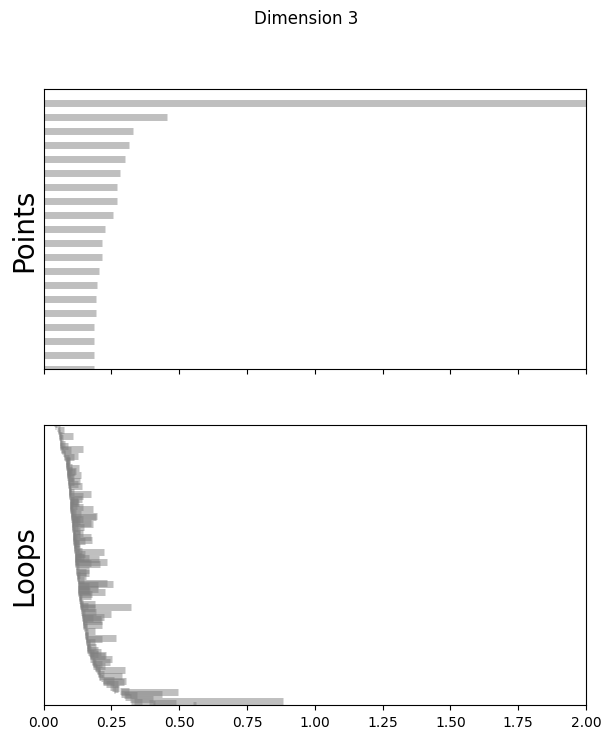

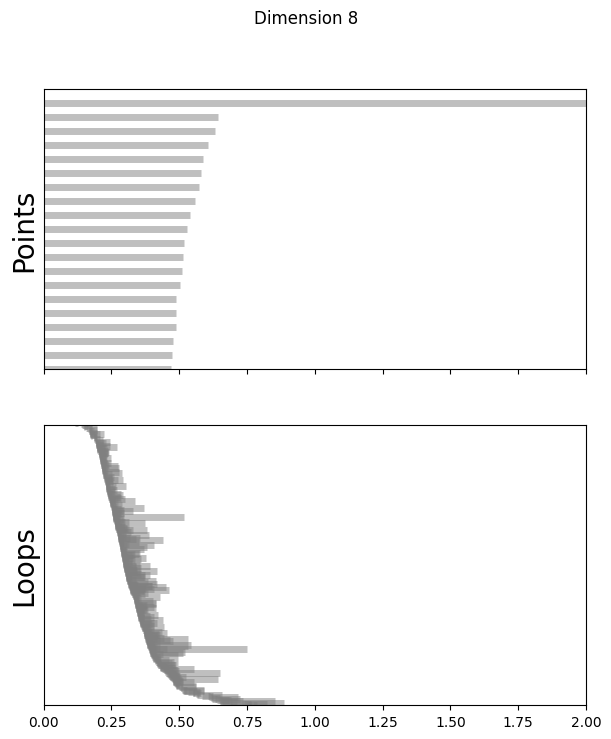

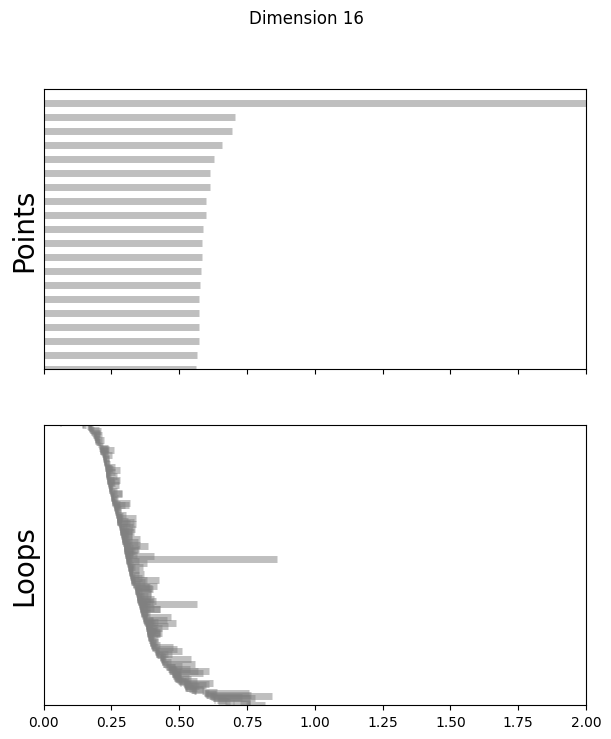

In [24]:
%matplotlib inline

for k in [3,8,16]:
    fig=plot_barcode(topology_dimension[k], maxdim)
    fig.suptitle(f'Dimension {k}')

In [32]:
np.shape(topology_random_dimension[3]['dgms'][0][:, 1])

(861,)

In [27]:
from persim import plot_diagrams

def read_lifespan(ripser_output, dim):
    dim_diff = ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
    if dim == 0:
        return dim_diff[~np.isinf(dim_diff)]
    else:
        return dim_diff

def get_max_lifespan(ripser_output_list, maxdim):
    lifespan_dic = {i: [] for i in range(maxdim+1)}
    for f in ripser_output_list:
        for dim in range(maxdim+1):
            lifespan = read_lifespan(f, dim)
            lifespan_dic[dim].extend(lifespan)
    return [max(lifespan_dic[i]) for i in range(maxdim+1)], lifespan_dic

def get_betti_number(ripser_output, shuffled_max_lifespan):
    bettis=[]
    for dim in range(len(ripser_output['dgms'])):
        lifespans=ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
        betti_d = sum(lifespans > shuffled_max_lifespan[dim] * 1.1)
        bettis.append(betti_d)
    return bettis

def plot_lifespan(topology_dgms, shuffled_max_lifespan, ax, label_vis, maxdim):
    plot_diagrams(
        topology_dgms,
        ax=ax,
        legend=True,
    )

    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[0], 2 + shuffled_max_lifespan[0]],
        color="C0",
        linewidth=3,
        alpha=0.5,

    )
    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[1], 2 + shuffled_max_lifespan[1]],
        color="orange",
        linewidth=3,
        alpha=0.5,

    )
    if maxdim == 2:
        ax.plot(
            [-0.50, 2],
            [-0.5 + shuffled_max_lifespan[2], 2 + shuffled_max_lifespan[2]],
            color="green",
            linewidth=3,
            alpha=0.5,
        )
    ax.set_xlabel("Birth", fontsize=15)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.tick_params(labelsize=13)
    if label_vis:
        ax.set_ylabel("Death", fontsize=15)
    else:
        ax.set_ylabel("")



In [33]:
fig = plt.figure(figsize=(18,5))
for n, dim in enumerate([3,8,16]):
    shuffled_max_lifespan, lifespan_dic = get_max_lifespan(topology_random_dimension[dim], maxdim)
    ax = fig.add_subplot(1,3,n+1)
    ax.set_title(f'Dimension {dim}')
    plot_lifespan(topology_dimension[dim]['dgms'], shuffled_max_lifespan, ax, True, maxdim)
    print(f"Betti No. for dimension {dim}: {get_betti_number(topology_dimension[dim], shuffled_max_lifespan)}")

3


TypeError: string indices must be integers

<Figure size 1800x500 with 0 Axes>